This notebook is for taking the output factors of a face-rhythm run and aligning the temporal factors to user provided event markers.\
A typical use case is for when the data is broken up into trials, and you wish to know how an animal or subject responds to an event/stimulus within each trial.

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot

fr.helpers.get_system_versions(verbose=True);

Operating System: Linux: 5.15.0-56-generic, #62~20.04.1-Ubuntu SMP Tue Nov 22 21:24:20 UTC 2022, x86_64, node: rich-L-CLASS
Conda Environment: FR
Python Version: 3.9.13
GCC Version: 9.4.0
PyTorch Version: 1.12.0+cu113
Numpy Version: 1.21.6
OpenCV Version: 4.6.0
face-rhythm Version: 0.1.0


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
directory_project = '/media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new_2/'
directory_videos  = '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06'

filename_strMatch = 'trial_.*mp4'  ## You can use regular expressions to search and match more complex strings

path_config, path_run_info, directory_project = fr.project.prepare_project(
    directory_project=directory_project,
    overwrite_config=False,  ## WARNING! CHECK THIS.
    mkdir=True,    
    initialize_visualization=True,    
    verbose=2,
)
figure_saver = fr.util.Figure_Saver(
    path_config=path_config,
    format_save=['png'],
    kwargs_savefig={'bbox_inches': 'tight', 'pad_inches': 0.1, 'transparent': True, 'dpi': 300},
    overwrite=False,
    verbose=2,
)

Initializing cv2.imshow
FR: Found config.yaml file at /media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new_2/config.yaml


## get some results data files

In [17]:
config = fr.util.load_config_file(path_config)
run_info = fr.util.load_run_info_file(path_run_info)

In [4]:
data_DatasetVideos = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'Dataset_videos.h5'))
pt_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'))
spec_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'VQT_Analyzer.h5'))
tca_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'TCA.h5'), return_lazy=False)

In [5]:
ds_factor = config['VQT_Analyzer']['params_VQT']['downsample_factor']
spec_x_axis = [x for x in spec_data['x_axis'].values()]
image_example = data_DatasetVideos['example_image']
factors = tca_data['factors_rearranged']['0']

In [6]:
print(f"Factor names: {factors.keys()}")

Factor names: dict_keys(['(xy points)', 'frequency', 'trials'])


define temporal factor(s)

In [7]:
name_tempFactor = 'trials'
factors_temporal = factors[name_tempFactor]
factors_temporal = [f for f in factors_temporal.values()] if isinstance(factors_temporal, dict) else factors_temporal

norm_factor = np.abs(np.concatenate(factors_temporal, axis=0)).std(0)

In [8]:
import pandas as pd

event_times = pd.read_excel('/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/reward frames_2.xlsx')['reward_frame']

In [45]:
idx_reward = event_times.to_numpy().astype(np.float32)
traces_windowed = []
windows = []
included = np.zeros((len(factors_temporal)), dtype=bool)
for ii,(trace, xaxis) in enumerate(zip(factors_temporal, spec_x_axis)):
    trace = np.abs(trace) / norm_factor[None,:]
    if (np.isnan(idx_reward[ii]) == False) and (idx_reward[ii] > 800):
        idx_reward_ds = np.argmin(np.abs(xaxis - idx_reward[ii]))
        window = (idx_reward_ds - 40, idx_reward_ds + 40)
        trace_windowed = trace[window[0]:window[1],:]
        traces_windowed.append(trace_windowed)
        windows.append(window)
        included[ii] = True
traces_windowed = np.stack(traces_windowed, axis=0)        

<IPython.core.display.Javascript object>


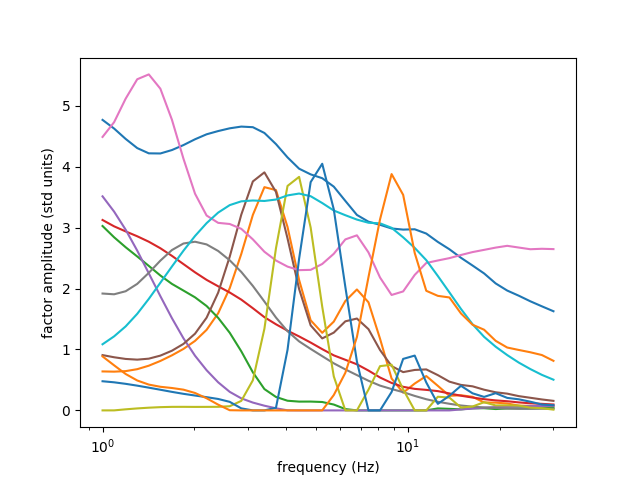

Text(0, 0.5, 'factor amplitude (std units)')

In [10]:
plt.figure()
plt.plot(spec_data['frequencies'], tca_data['factors_rearranged']['0']['frequency'] / tca_data['factors_rearranged']['0']['frequency'].std(0));
plt.xscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('factor amplitude (std units)')

<IPython.core.display.Javascript object>


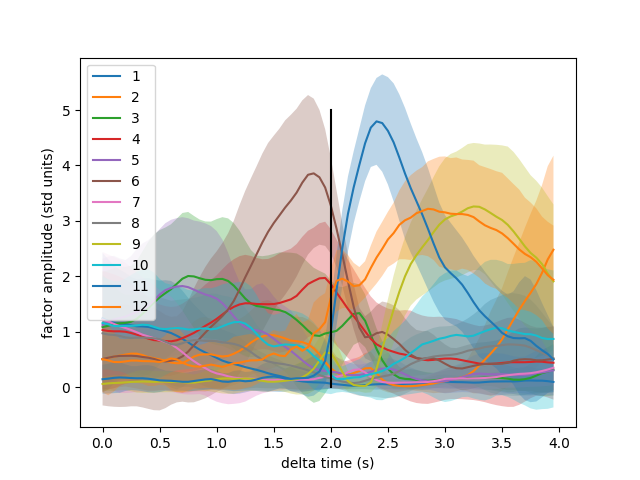

In [11]:
plt.figure()
for ii,trace in enumerate(traces_windowed.transpose(2,0,1)[:]):
    plt.plot(np.arange(trace.shape[1])/20, trace.mean(0))
#     plt.fill_between(np.arange(trace.shape[1])/20, trace.mean(0) + trace.std(0), trace.mean(0) - trace.std(0), alpha=0.3)
for ii,trace in enumerate(traces_windowed.transpose(2,0,1)[:]):
#     plt.plot(np.arange(trace.shape[1])/20, trace.mean(0))
    plt.fill_between(np.arange(trace.shape[1])/20, trace.mean(0) + trace.std(0), trace.mean(0) - trace.std(0), alpha=0.3)
#     if ii == 4:
#         break

plt.plot([2,2], [0,5], 'k')
plt.xlabel('delta time (s)')
plt.ylabel('factor amplitude (std units)')
plt.legend(np.arange(traces_windowed.shape[2])+1)

<IPython.core.display.Javascript object>


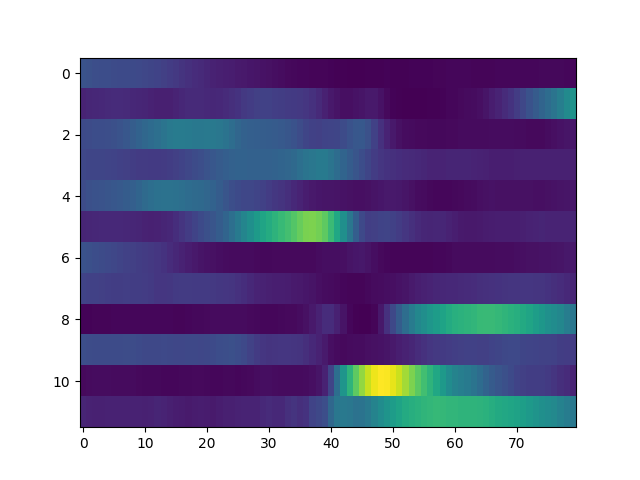

In [12]:
plt.figure()
plt.imshow(traces_windowed.mean(0).T, aspect='auto')

In [225]:
frame_visualizer = fr.visualization.FrameVisualizer(image_height_width=image_example.shape[1:])

factors_dots_complex = np.stack([p[:p.shape[0]//2,] + 1j*p[p.shape[0]//2:] for p in tca_data['factors_rearranged']['0']['(xy points)'].T], axis=1)

factors_dots_mag = np.abs(factors_dots_complex)
factors_dots_angle = np.angle(factors_dots_complex)

In [226]:
cmap_mag   = fr.helpers.simple_cmap(colors=[[0,0,0],[1,1,1]], name='mag')
cmap_angle = fr.helpers.simple_cmap(colors=[[0,0,1],[0.7,0,0.7],[1,0,0]], name='angle')
cmap_conj = fr.helpers.Cmap_conjunctive([cmap_mag, cmap_angle], normalize=True)

<IPython.core.display.Javascript object>


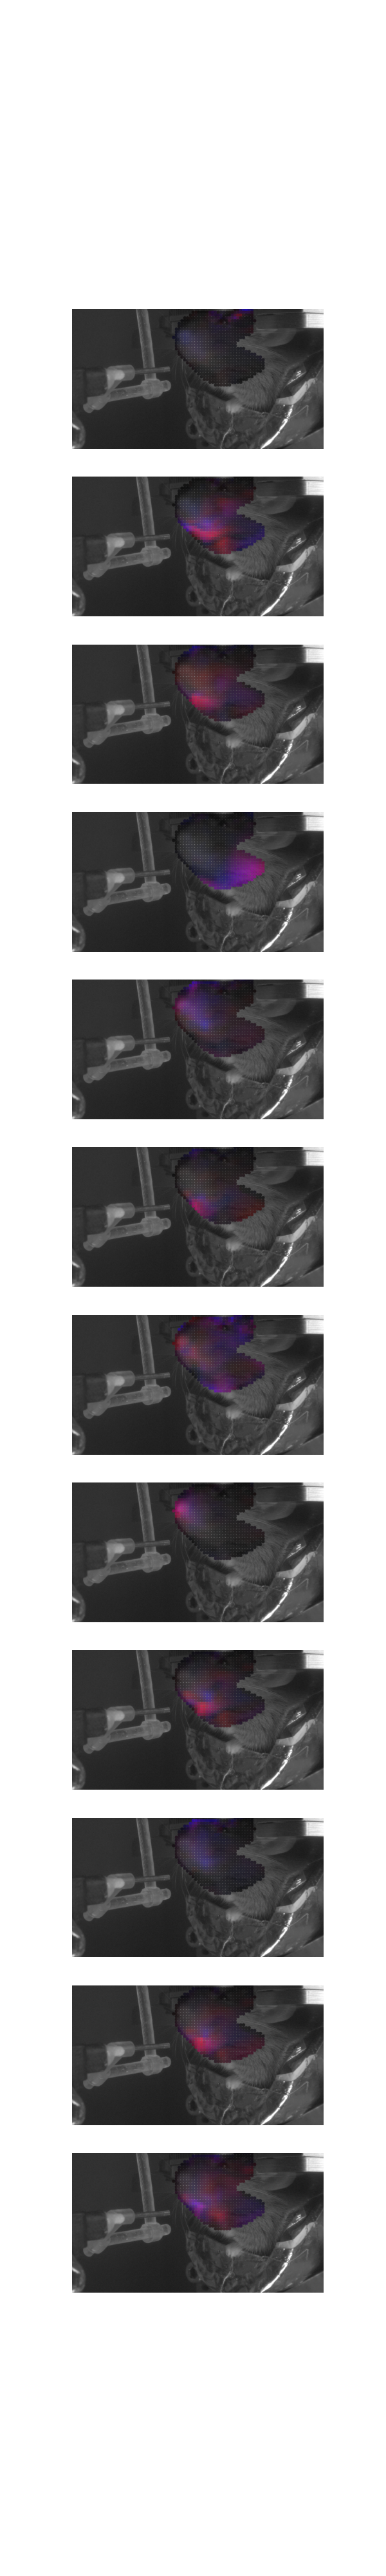

In [227]:
fig, axs = plt.subplots(12,1, figsize=(6,40))
for ii,(dots_mag, dots_angle) in enumerate(zip(factors_dots_mag.T, factors_dots_angle.T)):
    frame_with_points = frame_visualizer.visualize_image_with_points(
        image=image_example,
        points=[pt_data['point_positions'].astype(np.int64) for ii in range(12)],
        point_sizes=6,
        points_colors=[(cmap_conj(np.stack((dots_mag, dots_angle), axis=1))[:,:3])],
        alpha=0.6,
        error_checking=True
    )
    axs[ii].imshow(frame_with_points)
    axs[ii].axis('off')


In [16]:
%load_ext autoreload
%autoreload 2
import bnpm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
run_info['Dataset_videos']['metadata']['paths_videos']

['/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00000__2022-07-19_13-34-07.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00001__2022-07-19_13-34-51.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00002__2022-07-19_13-35-02.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00003__2022-07-19_13-35-14.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00004__2022-07-19_13-35-24.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00005__2022-07-19_13-35-36.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00006__2022-07-19_13-35-49.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_0

In [48]:
paths_videos = np.array(run_info['Dataset_videos']['metadata']['paths_videos'][:len(factors_temporal)])[included]

In [159]:
n_frames = np.array(run_info['Dataset_videos']['metadata']['num_frames'][:len(factors_temporal)])[included]

In [52]:
frame_idx_list = np.array(windows).T[None,:,:]

overlay_signals = [(f/f.max(0))[:,5][:,None]*255 for f in np.array(factors_temporal, dtype=object)[included]][:36]

spec_x_axis_inc = np.array(spec_x_axis[:len(factors_temporal)], dtype=object)[included]

In [271]:
import scipy.interpolate
overlay_signals_interp = [scipy.interpolate.interp1d(sx, o.squeeze(), kind='linear', bounds_error=False)(np.arange(n))[:,None] for sx,o,n in zip(spec_x_axis_inc, overlay_signals, n_frames)]

In [268]:
test = bnpm.video.make_tiled_video_array(
    paths_videos=paths_videos[:36], 
    frame_idx_list=(frame_idx_list[:,:,:36]*20).astype(int), 
    block_height_width=[200,360],
    n_channels=3, 
    tiling_shape=None, 
    dtype=np.uint8,
#     interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
    crop_idx=None,
    overlay_signals=overlay_signals_interp,
    overlay_idx=[180,200,0,360],
    overlay_color=[0,0.7,1.0],
    spacer_black_frames=0,
    pixel_val_range=None,
    verbose=True,
    )

 89%|██████████████████████████████████████▏    | 32/36 [04:52<00:36,  9.15s/it]


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.16s/it]


In [269]:
bnpm.video.play_video_cv2(test, frameRate=240, save_path='/home/rich/Desktop/prep_factor_video.avi')

saving to file /home/rich/Desktop/prep_factor_video.avi


100%|███████████████████████████████████████| 1600/1600 [00:50<00:00, 31.55it/s]

Video saved
